In [4]:
using PauliPropagation
using Plots
using Printf
using LinearAlgebra
using LaTeXStrings

In [5]:
function commutator2(A::Matrix, B::Matrix)
    return A * B - B * A
end

function thermalStateComparison(H, circuit, beta, theta, nq; max_weight=nq, min_abs_coeff=1e-10)
    analyticResult = imaginaryTimeEvolution(H, -beta)
    pstr = PauliString(nq, :I, 1)
    totalAngle = 0
    psum = PauliSum(pstr)
    while totalAngle < beta
        # psum = PauliSum(pstr)
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=true)
        totalAngle += imag(theta)
    end
    pstr = topaulistrings(psum)
    distance = computeTwoNorm(pstr, analyticResult, nq)
    return distance
end

function thermalStateExpectation(circuit, beta, theta, nq, operator; max_weight=nq, min_abs_coeff=1e-10)
    pstr = PauliString(nq, :I, 1)
    totalAngle = 0
    psum = PauliSum(pstr)

    while totalAngle < beta
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=true)
        totalAngle += imag(theta)
    end

    pstr = topaulistrings(psum)
    expectation = 0
    for i in 1:size(pstr)[1]
        string = inttostring(pstr[i].term, nq)
        if string == operator
            expectation = pstr[i].coeff
        end
    end
    expectation = 2^nq*expectation
    return expectation
end

function thermalStateExpectation2(circuit, nl, theta, nq, operator; max_weight=nq, min_abs_coeff=0)
    pstr = PauliString(nq, :I, 1)
    totalAngle = 0
    psum = PauliSum(pstr)

    layers = 0

    while layers < nl
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=true)
        layers += 1
    end

    pstr = topaulistrings(psum)
    expectation = 0
    for i in 1:size(pstr)[1]
        string = inttostring(pstr[i].term, nq)
        if string == operator
            expectation = pstr[i].coeff
        end
    end
    expectation = 2^nq*expectation
    return expectation
end

function thermalStateExpectation3(circuit, nl, theta, nq, pstr; max_weight=nq, min_abs_coeff=0)

    psum = PauliSum(PauliString(nq, :I, 1))
    layers = 0

    while layers < nl
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=true)
        layers += 1
    end
    psum2 = PauliSum(pstr)

    return overlapwithpaulisum(psum,psum2)*2^nq
end

function thermalStateExpectationComparison(H, circuit, beta, theta, nq, operator; max_weight=nq, min_abs_coeff=0, errorType="relative")
    analyticDensity = imaginaryTimeEvolution(H, -beta)
    pstr = PauliString(nq, :I, 1)
    totalAngle = 0
    psum = PauliSum(pstr)

    while totalAngle < beta
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=true)
        totalAngle += imag(theta)
    end

    pstr = topaulistrings(psum)
    expectationAnalytic = expectationValue(analyticDensity, operator)
    expectationPP = 0
    for i in 1:size(pstr)[1]
        string = inttostring(pstr[i].term, nq)
        if string == operator
            expectationPP = pstr[i].coeff
        end
    end
    expectationPP = 2^nq*expectationPP 
    if errorType == "absolute"
        error = abs(expectationPP - expectationAnalytic)
    elseif errorType == "relative"
        error = abs(expectationPP - expectationAnalytic)/abs(expectationAnalytic)
    end
    return error
end

function XMatrix(n::Int, i::Int)
    Xmat = [0 1; 1 0]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Xmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Xmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function YMatrix(n::Int, i::Int)
    Ymat = [0 -im; im 0]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Ymat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Ymat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function ZMatrix(n::Int, i::Int)
    Zmat = [1 0; 0 -1]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Zmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Zmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function imaginaryTimeEvolution(h::Matrix, beta::Float64)
    operator = exp(-beta*h)
    return operator/tr(exp(-beta*h))
end

function imaginaryTimeEvolutionState(h::Matrix, beta::Float64, state::Vector)
    operator = exp(-beta*h)*state
    return operator/LinearAlgebra.norm(operator)
end

function comparison(P::Matrix, Q::Matrix, beta::Float64)
    num = exp(-beta/2*P)*Q*exp(-beta/2*P)
    C = commutator2(P, Q)
    if (LinearAlgebra.norm(C) < 1e-3)
        analytic = cosh(beta)*Q-sinh(beta)*P*Q
    else
        analytic = Q
    end 
    println("Numerical: ", num)
    println("Analytic: ", analytic)
    println(LinearAlgebra.norm(num-analytic))
end
function interpretPauli(p::String)
    I = [1 0; 0 1]
    X = [0 1; 1 0]
    Y = [0 -1im; 1im 0]
    Z = [1 0; 0 -1]

    if p[1] == 'I'
        mat = I
    elseif p[1] == 'X'
        mat = X
    elseif p[1] == 'Y'
        mat = Y
    elseif p[1] == 'Z'
        mat = Z
    end

    for i in 2:length(p)
        if p[i] == 'I'
            mat = kron(mat, I)
        elseif p[i] == 'X'
            mat = kron(mat, X)
        elseif p[i] == 'Y'
            mat = kron(mat, Y)
        elseif p[i] == 'Z'
            mat = kron(mat, Z)
        end
    end
    return mat
end

function generatePauliBasis(nqubits::Int)
    basis = Vector{String}(undef, 4^nqubits)
    for i in 1:4^nqubits
        basis[i] = join(rand(['I', 'X', 'Y', 'Z'], nqubits))
    end
    return basis
end

function computeTwoNorm(pstr::Vector, rho::Matrix, nq::Int)
    A = 0
    B = LinearAlgebra.norm(rho)^2
    mix = 0
    for i in 1:size(pstr)[1]
        A += abs(pstr[i].coeff)^2
        string = (inttostring(pstr[i].term,nq))
        mix += pstr[i].coeff*tr(rho*interpretPauli(string))
    end
    A *= 2^nq
    return A+B-2*mix
end

function expectationValue(rho::Matrix, pauli::String)
    mat = interpretPauli(pauli)
    return tr(rho*mat)
end

expectationValue (generic function with 1 method)

In [6]:
function PauliToTransferMap(pauli,theta)
    mat = tomatrix(pauli, theta)

    # the Pauli basis matrices
    ptm = calculateptm(mat; heisenberg=false)
    # the Pauli basis transfermaps
    map = totransfermap(ptm)
    return map
end

PauliToTransferMap (generic function with 1 method)

In [7]:
nq = 6
H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

densityExponential = imaginaryTimeEvolution(H, -10.0);

In [8]:
θ = 0.10im

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);

nq = 6
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);


In [9]:
nls = 100
nq = 6
pstr = PauliString(nq, :I, 1)
psum = PauliSum(pstr)

beta = Float64[]
overlapsEvery = Float64[]
psumEvery = psum
for i in 1:nls
    psum = propagate!(circuit, psum; normalization=true)
    #push!(overlapsEvery, overlapbyorthogonality(psumEvery, I))
    push!(beta, 0.1*i)
end


In [10]:
pstr = topaulistrings(psum)
a = computeTwoNorm(pstr, densityExponential, 6)   


0.005319522339718219 - 0.0im

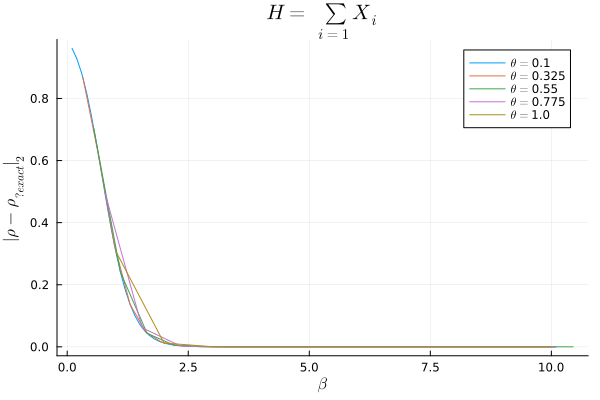

In [11]:
θ = LinRange(0.1, 1.0, 5) * 1im

nq = 6
H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        #H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

densityExponential = imaginaryTimeEvolution(H, -50.0);
plot(xlabel = L"\beta", ylabel = L"\| \rho - \rho_{\text{exact}} \|_2", title = L"$H = \sum_{i=1} X_i$", legend = :topright)


for i in 1:size(θ)[1]
    # the computational basis matrices
    rzmat = tomatrix(PauliRotation(:Z, 1), θ[i])
    rxmat = tomatrix(PauliRotation(:X, 1), θ[i])
    rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ[i])


    # the Pauli basis matrices
    rzptm = calculateptm(rzmat; heisenberg=false)
    rxptm = calculateptm(rxmat; heisenberg=false)
    rzzptm = calculateptm(rzzmat; heisenberg=false)

    # the Pauli basis transfermaps
    rzmap = totransfermap(rzptm)
    rxmap = totransfermap(rxptm)
    rzzmap = totransfermap(rzzptm);


    nq = 6
    topology = bricklayertopology(nq)

    # the circuit
    circuit = Gate[]
    append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
    #append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);


    pstr = PauliString(nq, :I, 1)
    psum = PauliSum(pstr)
    beta = Float64[]
    distance = Float64[]
    psumEvery = psum
    totalAngle = 0
    while totalAngle < 10
        psum = propagate!(circuit, psum, normalization=true)
        pstr = topaulistrings(psum)
        push!(distance, computeTwoNorm(pstr, densityExponential, 6))
        totalAngle += imag(θ[i])
        push!(beta, totalAngle)
    end
    plot!(beta, distance, label = L"\theta = "*string(imag(θ[i])))
end
display(plot!())

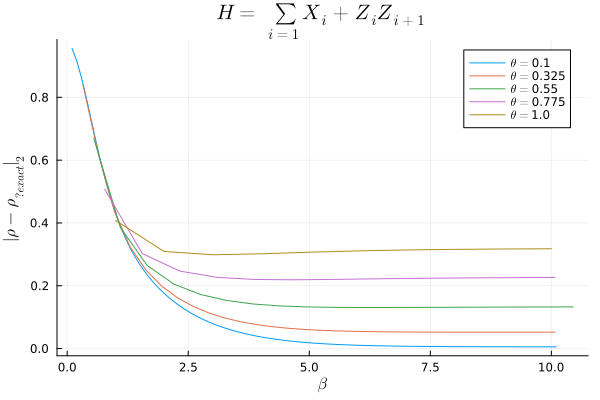

In [12]:
θ = LinRange(0.1, 1.0, 5) * 1im

nq = 6
H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

densityExponential = imaginaryTimeEvolution(H, -50.0);
plot(xlabel = L"\beta", ylabel = L"\| \rho - \rho_{\text{exact}} \|_2", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$", legend = :topright)


for i in 1:size(θ)[1]
    # the computational basis matrices
    rzmat = tomatrix(PauliRotation(:Z, 1), θ[i])
    rxmat = tomatrix(PauliRotation(:X, 1), θ[i])
    rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ[i])


    # the Pauli basis matrices
    rzptm = calculateptm(rzmat; heisenberg=false)
    rxptm = calculateptm(rxmat; heisenberg=false)
    rzzptm = calculateptm(rzzmat; heisenberg=false)

    # the Pauli basis transfermaps
    rzmap = totransfermap(rzptm)
    rxmap = totransfermap(rxptm)
    rzzmap = totransfermap(rzzptm);


    nq = 6
    topology = bricklayertopology(nq)

    # the circuit
    circuit = Gate[]
    append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
    append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);


    pstr = PauliString(nq, :I, 1)
    psum = PauliSum(pstr)
    beta = Float64[]
    distance = Float64[]
    psumEvery = psum
    totalAngle = 0
    while totalAngle < 10
        psum = propagate!(circuit, psum; normalization=true)
        pstr = topaulistrings(psum)
        push!(distance, computeTwoNorm(pstr, densityExponential, 6))
        totalAngle += imag(θ[i])
        push!(beta, totalAngle)
    end
    plot!(beta, distance, label = L"\theta = "*string(imag(θ[i])))
end
display(plot!())

In [13]:
θ = 0.10im

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);

nq = 6
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);


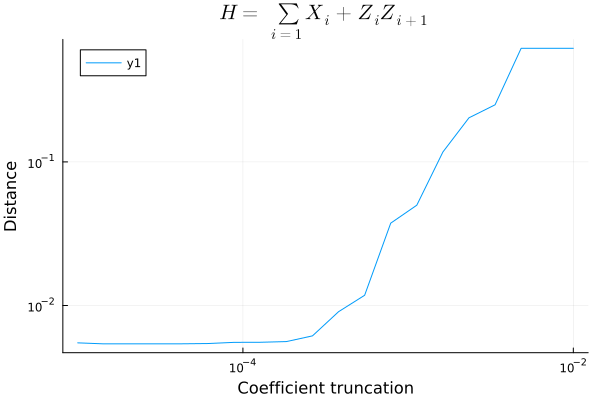

In [14]:
minCoeff = 10 .^ LinRange(-5, -2, 20)
distance = Float64[]
nls = 100
nq = 6
pstr = PauliString(nq, :I, 1)
for i in minCoeff
    distanceLoop = Float64[]
    psum = PauliSum(pstr)
    for j in 1:nls
        psum = propagate!(circuit, psum; min_abs_coeff=i, normalization=true)
        pstr = topaulistrings(psum)
        push!(distanceLoop, computeTwoNorm(pstr, densityExponential, nq))
    end
    push!(distance, distanceLoop[end])
end

plot(minCoeff, distance, ylabel="Distance", xlabel="Coefficient truncation", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$",xscale=:log10, yscale=:log10)



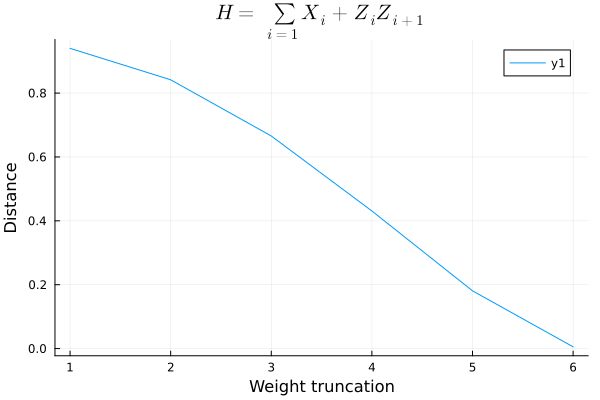

In [15]:
nq = 6
weightCoeff = (1:1:nq)
distance = Float64[]
nls = 100
pstr = PauliString(nq, :I, 1)
for i in weightCoeff
    distanceLoop = Float64[]
    psum = PauliSum(pstr)
    for j in 1:nls
        psum = propagate!(circuit, psum; max_weight=i, normalization=true)
        pstr = topaulistrings(psum)
        push!(distanceLoop, computeTwoNorm(pstr, densityExponential, nq))
    end
    push!(distance, distanceLoop[end])
end

plot(weightCoeff, distance, ylabel="Distance", xlabel="Weight truncation", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$")



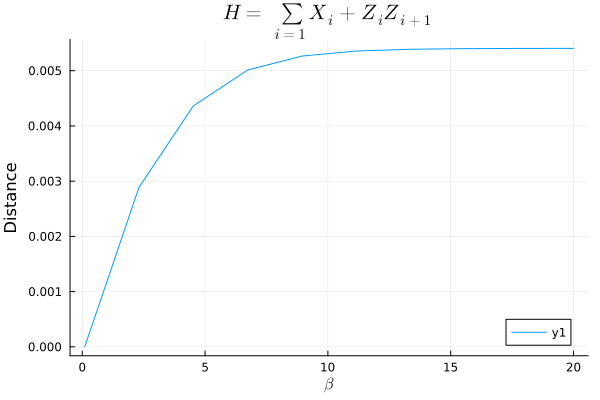

In [16]:
theta = 0.10im
θ = theta
betas = LinRange(0.1, 20, 10)
nq = 6
distances = Float64[]
H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);

for i::Float64 in betas
    distance = thermalStateComparison(H, circuit, i, theta, nq)
    push!(distances, distance)
end
plot(betas, distances, ylabel="Distance", xlabel=L"\beta", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$")


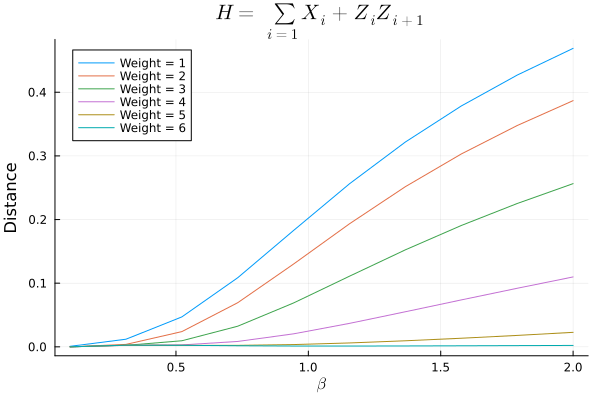

In [17]:
theta = 0.10im
θ = theta
betas = LinRange(0.1, 2, 10)
nq = 6

H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);

plot( ylabel="Distance", xlabel=L"\beta", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$")
weights = 1:1:6
for j in weights
    distances = Float64[]
    for i::Float64 in betas
        distance = thermalStateComparison(H, circuit, i, theta, nq, max_weight=j)
        push!(distances, distance)
    end
    plot!(betas, distances, label = "Weight = "*string(j))
end
display(plot!())


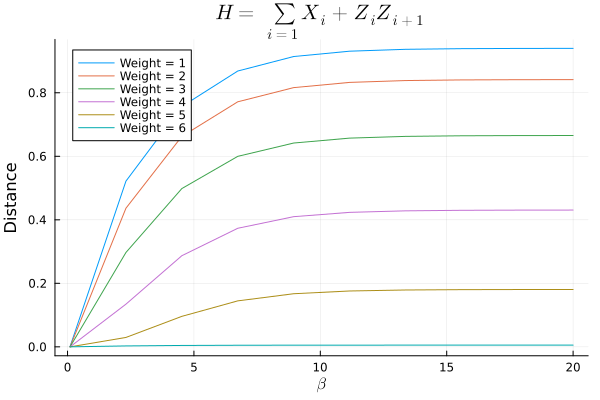

In [18]:
theta = 0.10im
θ = theta
betas = LinRange(0.1, 20, 10)
nq = 6

H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);

plot( ylabel="Distance", xlabel=L"\beta", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$")
weights = 1:1:6
for j in weights
    distances = Float64[]
    for i::Float64 in betas
        distance = thermalStateComparison(H, circuit, i, theta, nq, max_weight=j)
        push!(distances, distance)
    end
    plot!(betas, distances, label = "Weight = "*string(j))
end
display(plot!())


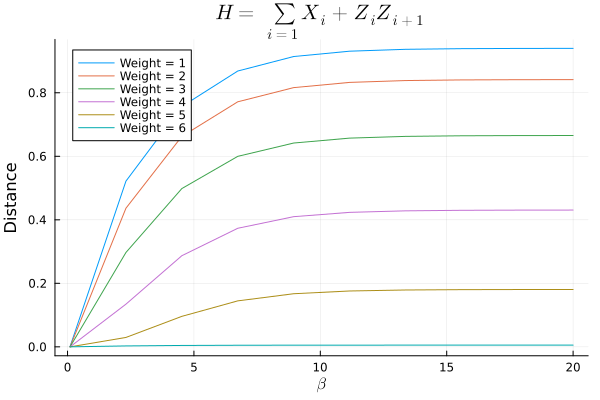

In [19]:
theta = 0.10im
θ = theta
betas = LinRange(0.1, 20, 10)
nq = 6

H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);

plot( ylabel="Distance", xlabel=L"\beta", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$")
weights = 1:1:6
for j in weights
    distances = Float64[]
    for i::Float64 in betas
        distance = thermalStateComparison(H, circuit, i, theta, nq, max_weight=j)
        push!(distances, distance)
    end
    plot!(betas, distances, label = "Weight = "*string(j))
end
display(plot!())


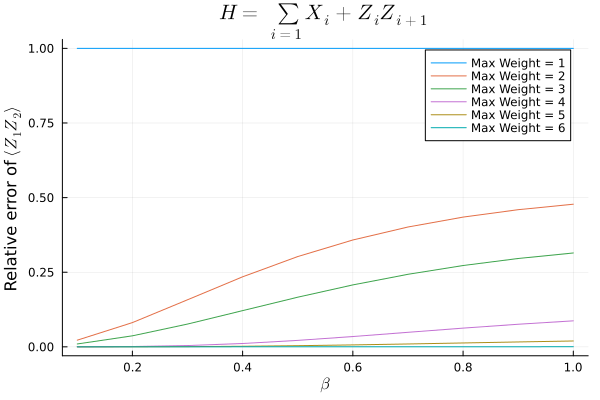

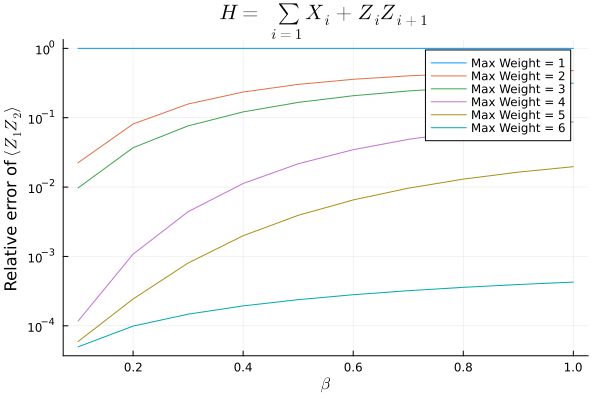

In [20]:
theta = 0.001im
θ = theta
betas = LinRange(0.1, 1.0, 10)
nq = 6

H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);

operator = "ZZIIII"

plot(ylabel=L"Relative error of $\langle Z_1Z_2 \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$")
weights = 1:1:6
for j in weights
    errors = Float64[]
    for i::Float64 in betas
        error = thermalStateExpectationComparison(H, circuit, i, theta, nq, operator; max_weight=j)
        push!(errors, error)
    end
    plot!(betas, errors, label = "Max Weight = "*string(j))
end
display(plot!())
plot!(yscale=:log10)
display(plot!())


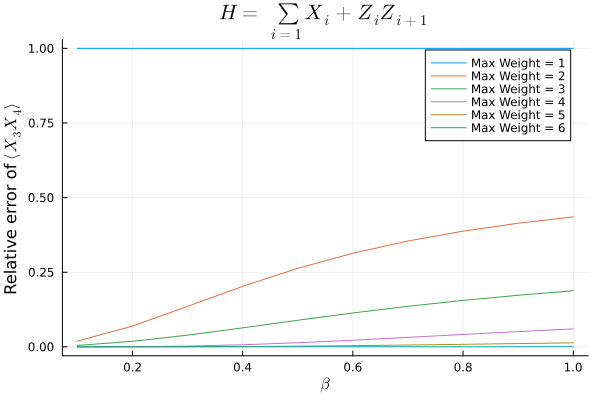

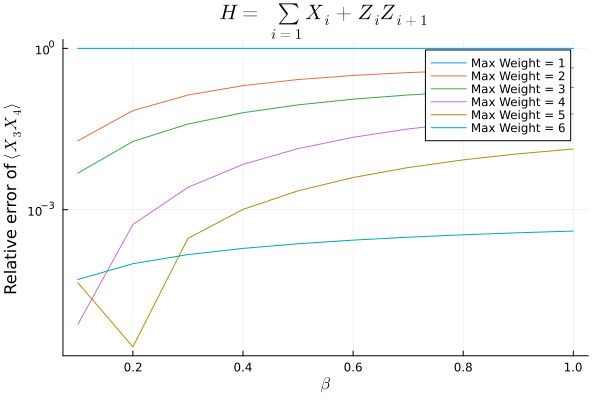

In [21]:
theta = 0.001im
θ = theta
betas = LinRange(0.1, 1.0, 10)
nq = 6

H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);

operator = "IIXXII"

plot(ylabel=L"Relative error of $\langle X_3X_4 \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$")
weights = 1:1:6
for j in weights
    errors = Float64[]
    for i::Float64 in betas
        error = thermalStateExpectationComparison(H, circuit, i, theta, nq, operator; max_weight=j)
        push!(errors, error)
    end
    plot!(betas, errors, label = "Max Weight = "*string(j))
end
display(plot!())
plot!(yscale=:log10)
display(plot!())

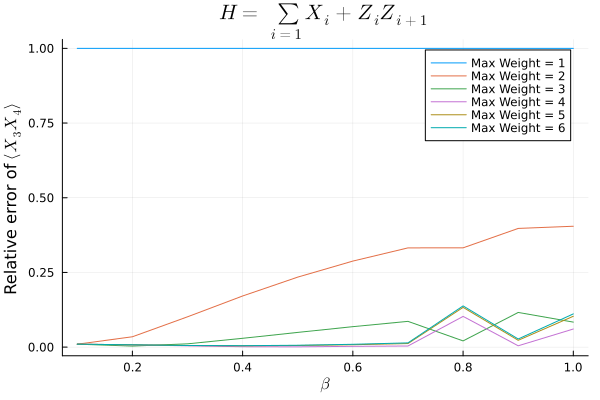

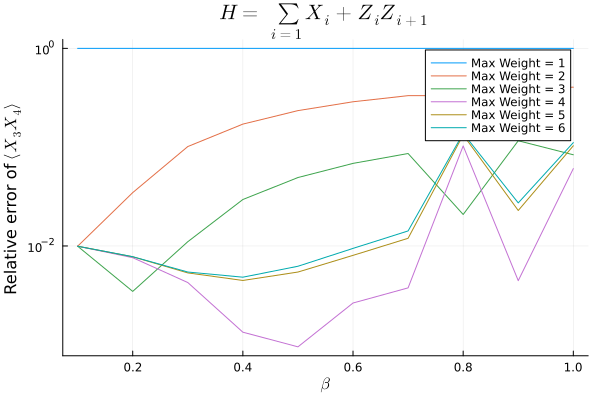

In [22]:
theta = 0.1im
θ = theta
betas = LinRange(0.1, 1.0, 10)
nq = 6

H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);

operator = "IIXXII"

plot(ylabel=L"Relative error of $\langle X_3X_4 \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$")
weights = 1:1:6
for j in weights
    errors = Float64[]
    for i::Float64 in betas
        error = thermalStateExpectationComparison(H, circuit, i, theta, nq, operator; max_weight=j)
        push!(errors, error)
    end
    plot!(betas, errors, label = "Max Weight = "*string(j))
end
display(plot!())
plot!(yscale=:log10)
display(plot!())

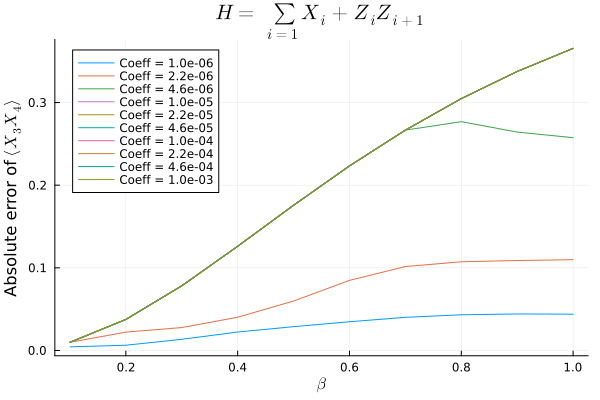

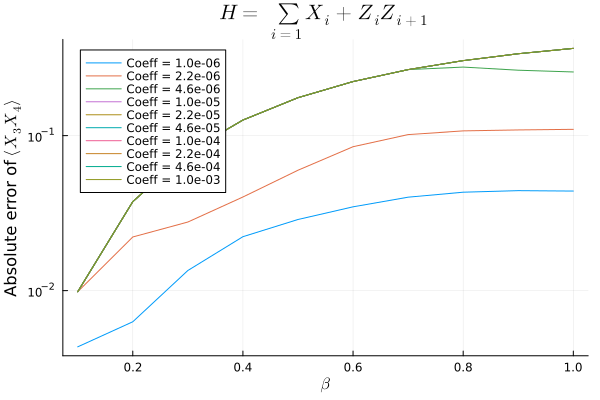

In [23]:
theta = 0.001im
θ = theta
betas = LinRange(0.1, 1.0, 10)
nq = 6

H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);

operator = "IIXXII"

plot(ylabel=L"Absolute error of $\langle X_3X_4 \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$")
coeff = 10 .^ LinRange(-6, -3, 10)
for j in coeff
    errors = Float64[]
    for i::Float64 in betas
        error = thermalStateExpectationComparison(H, circuit, i, theta, nq, operator; min_abs_coeff=j, errorType="absolute")
        push!(errors, error)
    end
    plot!(betas, errors, label="Coeff = " * @sprintf("%.1e", j))
end
display(plot!())
plot!(yscale=:log10)
display(plot!())

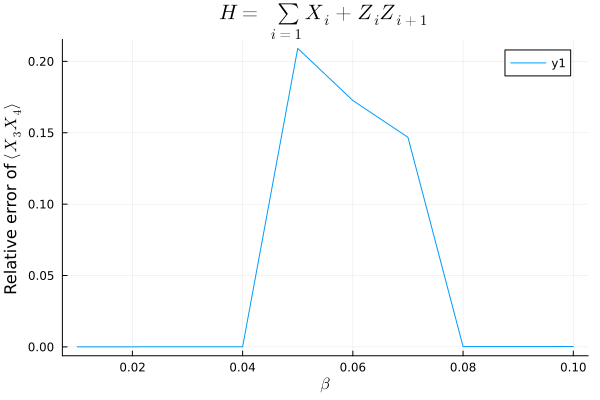

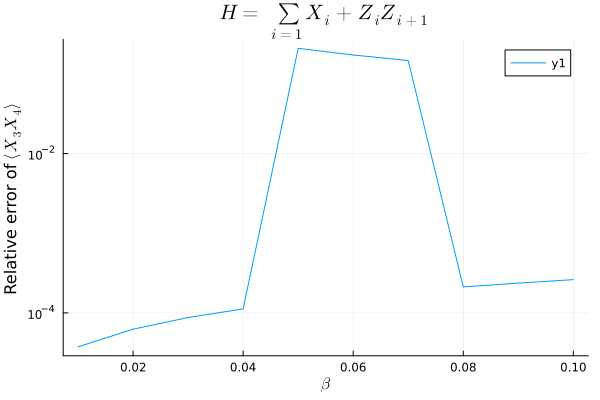

In [24]:
theta = 0.005im
θ = theta
betas = LinRange(0.01, 0.1, 10)
nq = 8

H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);

operator = "IIXXIIII"

plot(ylabel=L"Relative error of $\langle X_3X_4 \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$")
weights = 8
errors = Float64[]
for i::Float64 in betas
    error = thermalStateExpectationComparison(H, circuit, i, theta, nq, operator; max_weight=8)
    push!(errors, error)
end
plot!(betas, errors)#, label = "Max Weight = "*string(j))

display(plot!())
plot!(yscale=:log10)
display(plot!())

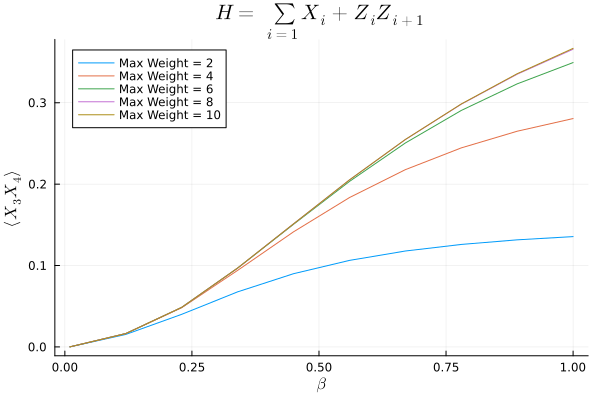

In [25]:
theta = 0.01im
θ = theta
betas = LinRange(0.01, 1.0, 10)
nq = 10

H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);

operator = "IIXXIIIIII"

plot(ylabel=L"$\langle X_3X_4 \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$")
weights = 2:2:10
for j in weights
    expectations = Float64[]
    for i::Float64 in betas
        expectation = thermalStateExpectation(circuit, i, theta, nq, operator; max_weight=j)
        push!(expectations, expectation)
    end
    plot!(betas, expectations, label = "Max Weight = "*string(j))
end
display(plot!())


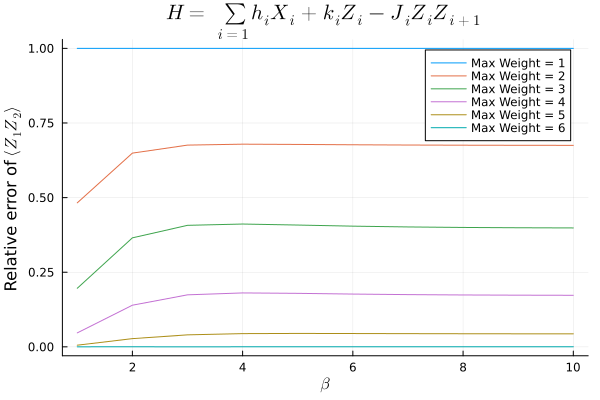

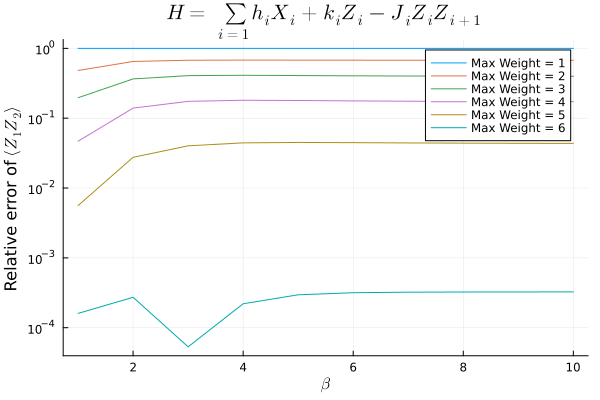

In [26]:
theta = 0.01im
θ = theta
betas = LinRange(1.0, 10.0, 10)
nq = 6
Jii = rand(nq)
h_perp = rand(nq)
h_para = rand(nq)

H = I(2^nq)
for i in 1:nq
    H += h_para[i]*XMatrix(nq, i)
    H += h_perp[i]*ZMatrix(nq, i)
    if i < nq
        H -= Jii[i]*(ZMatrix(nq, i)*ZMatrix(nq, i+1))
    end
end

circuit = Gate[]
topology = bricklayertopology(nq)
append!(circuit, TransferMapGate(PauliToTransferMap(PauliRotation(:Z, 1), h_perp[ii]*θ),ii) for ii in 1:nq)
append!(circuit, TransferMapGate(PauliToTransferMap(PauliRotation(:X, 1), h_para[ii]*θ),ii) for ii in 1:nq)
append!(circuit, TransferMapGate(PauliToTransferMap(PauliRotation([:Z, :Z], [1, 2]), -Jii[ii]*θ),[ii,ii+1]) for ii in 1:nq-1)

operator = "ZZIIII"

plot(ylabel=L"Relative error of $\langle Z_1Z_2 \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} h_i X_i + k_i Z_i -J_i Z_iZ_{i+1}$")
weights = 1:1:6
for j in weights
    errors = Float64[]
    for i::Float64 in betas
        error = thermalStateExpectationComparison(H, circuit, i, theta, nq, operator; max_weight=j)
        push!(errors, error)
    end
    plot!(betas, errors, label = "Max Weight = "*string(j))
end
display(plot!())
plot!(yscale=:log10)
display(plot!())


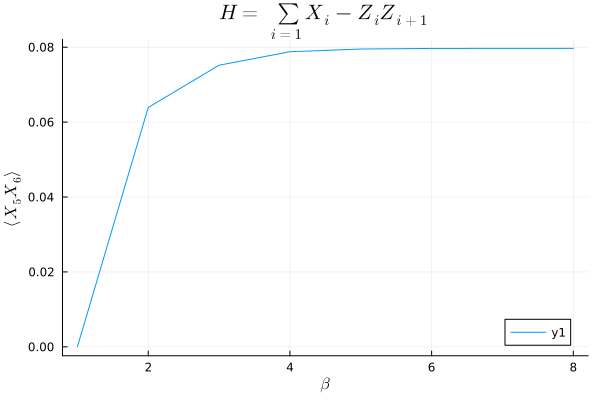

In [27]:
theta = 0.1im
θ = theta
nq = 10

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);

operator = join([i in (5, 6) ? "X" : "I" for i in 1:nq])

plot(ylabel=L"$\langle X_5X_6 \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} X_i - Z_iZ_{i+1}$")
weights = 1:1:8
nl = 3
expectations = Float64[]

for j in weights
    expectation = thermalStateExpectation2(circuit, nl, theta, nq, operator; max_weight=j)
    push!(expectations, expectation)
end

plot!(weights, expectations)
display(plot!())


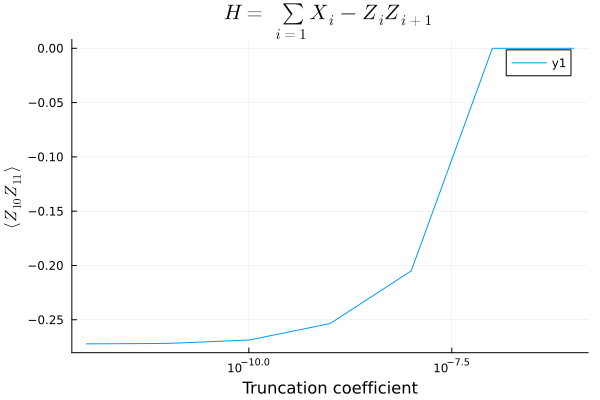

In [28]:
theta = 0.1im
θ = theta
nq = 20

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);

pstr = PauliString(nq, [:Z,:Z], [10,11])

plot(ylabel=L"$\langle Z_{10}Z_{11} \rangle$", xlabel="Truncation coefficient", title = L"$H = \sum_{i=1} X_i - Z_iZ_{i+1}$")
trunc_coeffs = 10.0 .^ (-6:-1:-12)
nl = 3
expectations = Float64[]

for j in trunc_coeffs
    expectation = thermalStateExpectation3(circuit, nl, theta, nq, pstr; min_abs_coeff=j)
    push!(expectations, expectation)
end

plot!(trunc_coeffs, expectations)
plot!(xscale=:log10)
display(plot!())


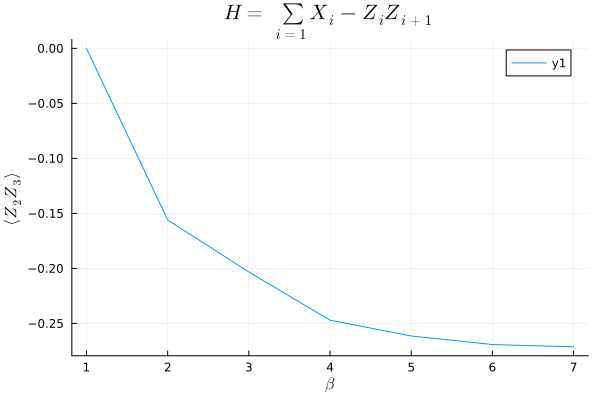

In [29]:
theta = 0.1im
θ = theta
nq = 20

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);

pstr = PauliString(nq, [:Z,:Z], [2,3])

plot(ylabel=L"$\langle Z_{2}Z_{3} \rangle$", xlabel=L"\beta", title = L"$H = \sum_{i=1} X_i - Z_iZ_{i+1}$")
weights = 1:1:7
nl = 3
expectations = Float64[]

for j in weights
    expectation = thermalStateExpectation3(circuit, nl, theta, nq, pstr; max_weight=j)
    push!(expectations, expectation)
end

plot!(weights, expectations)
display(plot!())
